# NL-EIG Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the nonlinear system with known eigenpairs.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | Nonlinear System with Known Eigenpairs                                                                                                                                                                                                         |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | All eigenpairs with feasible residuals                                                                                                                                                                                                         |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |


In [2]:
# load  the modules

import os
import sys

sys.path.append("../")

import numpy as np

import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
/Users/jianqiang/Downloads/Residual-Dynamic-Mode-Decomposition-1/examples/../ddrv/viz/vis_vector_field_2d.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


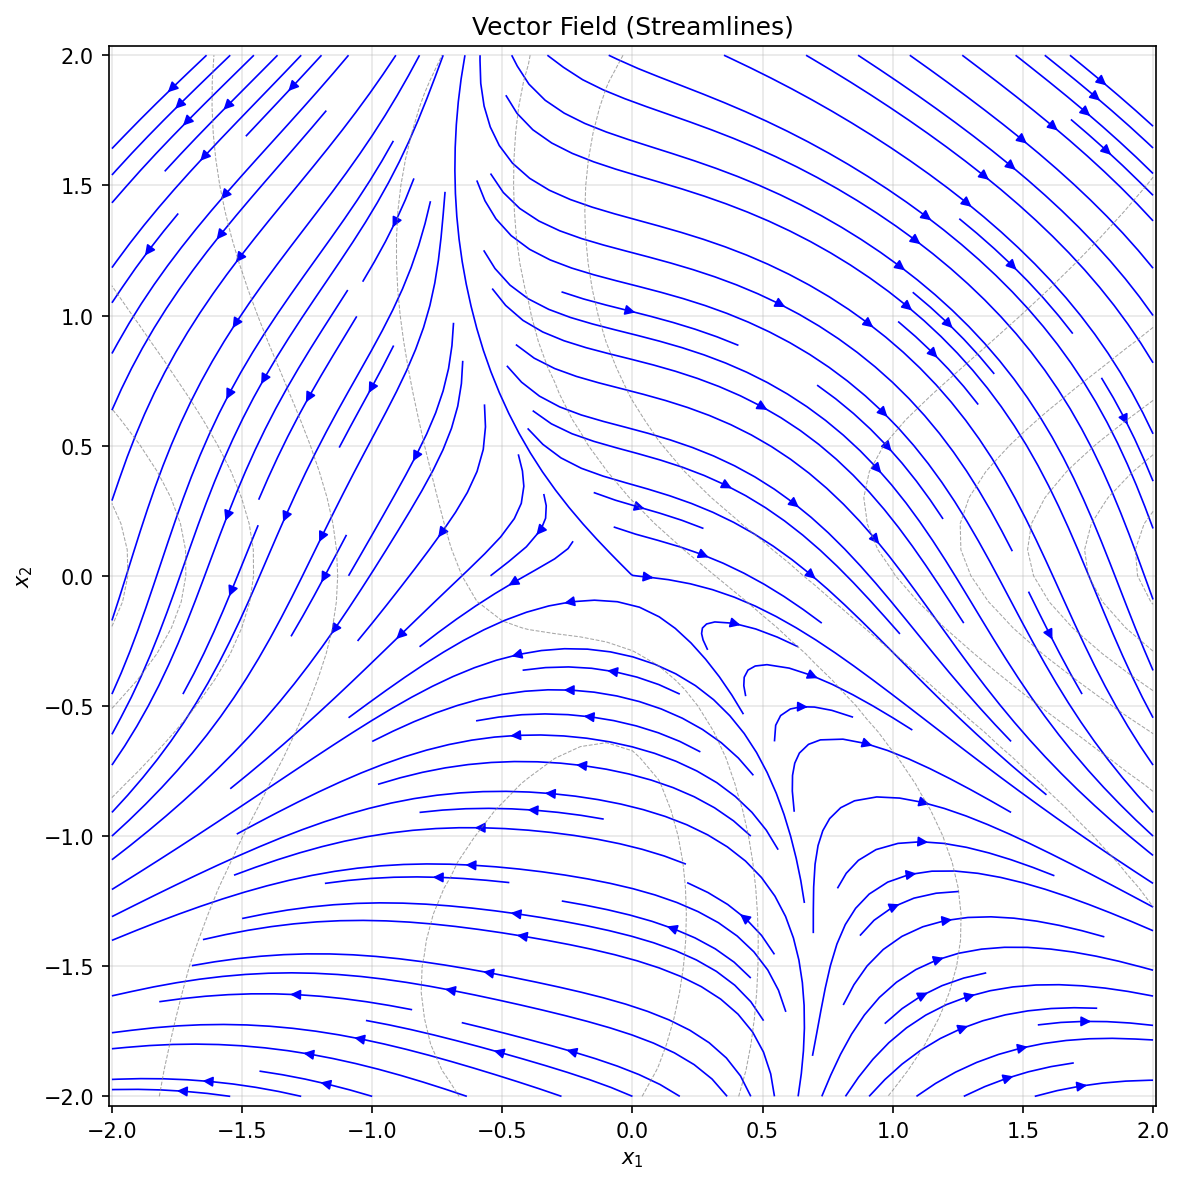

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [3]:
# define the dynamical system
NL_EIG = ddrv.dynamic.NL_EIG(lambda1=-1.0, lambda2=2.5)
ddrv.viz.vis_vector_field_2d(
    NL_EIG.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    step_size=0.1,
)

generated 1000 trajectories in batch (odeint), 10 steps, 0.05 time step...
(11, 1000, 2)


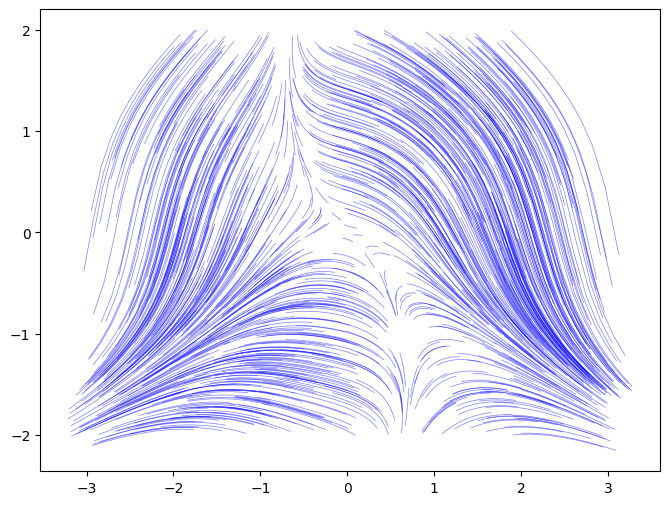

In [6]:
# set the seed for reproducibility
np.random.seed(0)

DELTA_T = 0.05

# generate the trajectory data
traj_data = ddrv.common.generate_trajectory_data(
    NL_EIG,
    num_samples=1000,
    num_steps=10,
    delta_t=DELTA_T,
    domain=[[-2, 2], [-2, 2]],
)
print(traj_data.shape)

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data)

In [7]:
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
X = traj_data[:-1, :, :].reshape(-1, 2)
Y = traj_data[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(10000, 2) (10000, 2)


In [ ]:
# now apply the resdmd algorithm

L, V, residuals, observables, PX, PY, K = ddrv.algo.resdmd(
    X, Y, observe_params={"basis": "poly", "degree": 9}
)

print(
    L.shape,
    V.shape,
    residuals.shape,
    observables.shape,
)

PX.shape, V.shape (10000, 55) (55, 55)
(55,) (55, 55) (55,) (2, 55)
